# Intent-to-Treat (ITT) vs. Naive Estimator Simulation

This notebook demonstrates why we cannot simply compare patients who *took* a treatment vs. those who didn't in a randomized control trial (RCT) when there is non-compliance.

### The Scenario: A Vitamin Study
We are testing a new vitamin. However, we have a problem called **Healthy User Bias**:
1.  **Randomization ($Z$):** Patients are randomly assigned to receive the vitamin ($Z=1$) or a placebo ($Z=0$).
2.  **Compliance ($D$):** Patients choose whether to actually take the pill. 
    *   *Problem:* **Health Conscious** people are much more likely to take the vitamin if assigned.
    *   *Problem:* **Health Conscious** people also have higher baseline health scores naturally.

### The Estimators
*   **Naive Estimator (Per-Protocol):** Compares $D=1$ vs. $D=0$ after getting rid of patients who were assigned to take the vitamin and did not comply (Z=1, D=0). 
    *   *Hypothesis:* This will be **biased upwards** because the $D=1$ group is disproportionately full of healthy people.
*   **Intent-to-Treat (ITT):** Compares $Z=1$ vs. $Z=0$.
    *   *Hypothesis:* This preserves randomization and is **unbiased**, though it may dilute the effect size since not everyone took the medicine.

---

In [91]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [92]:
# data generation parameters
N = 10000
BASELINE_HEALTH_SCORE = 70
TREATMENT_EFFECT = 4
CONFOUNDER_EFFECT = 10

In [93]:
np.random.seed(67)

Z = np.repeat([0, 1], N/2) # 50% treated (1), 50% control (0) # Z = Assigned Treatment (Randomized)
np.random.shuffle(Z)

is_health_conscious = np.random.choice((0,1), size = N, p = (0.5, 0.5)) # 50% of people are not health conscious

probs = np.where(is_health_conscious == 1, 0.95, 0.05) # health conscious people have a 95% chance of taking the pill

desire = np.random.binomial(n = 1, p = probs, size = N) # desire to take pill (1 = Yes, 0 = No)

D = Z*desire # have to 1. Be assigned to treatment group 2. Have the desire to take the pill to actually be treated # D = Actual Treatment (Observed)
# ASSUMPTION: Patients in the control group cannot ever actually be in the treated group (take the vitamin) whether they choose to take the placebo pill or not

health_score = BASELINE_HEALTH_SCORE + (D*TREATMENT_EFFECT)  + (is_health_conscious*CONFOUNDER_EFFECT) + np.random.normal(size = N)

df = pd.DataFrame({
    'patient_id' : np.arange(N),
    'Z' : Z,
    'D' : D,
    'is_health_conscious' : is_health_conscious,
    'health_score' : health_score    
})

In [94]:
# naive approach: only analyze people who complied
# 1. People who were assigned to take the vitamin and took it (Z = 1, D = 1)
# 2. People who were assigned to tak the placebo and took it (Z = 0, D = 0)

condition_compliers = (
    ((df['Z'] == 1) & (df['D'] == 1)) | 
    ((df['Z'] == 0) & (df['D'] == 0))
)

df_naive = df[condition_compliers].copy()

naive_model = smf.ols('health_score ~ D', data=df_naive).fit()
print(naive_model.summary())

                            OLS Regression Results                            
Dep. Variable:           health_score   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     6160.
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:49:24   Log-Likelihood:                -21686.
No. Observations:                7490   AIC:                         4.338e+04
Df Residuals:                    7488   BIC:                         4.339e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.1195      0.062   1213.440      0.0

The naive approach overestimates the effect of the vitamin. This is because when we filter to only compliers, we are deleting the lazy, non-health conscious people from the treated group. Since being health conscious also affects a patient's health score, the treated and control groups are no longer comparable, as the proportion of health-conscious people in the treated group is now larger than the control group.

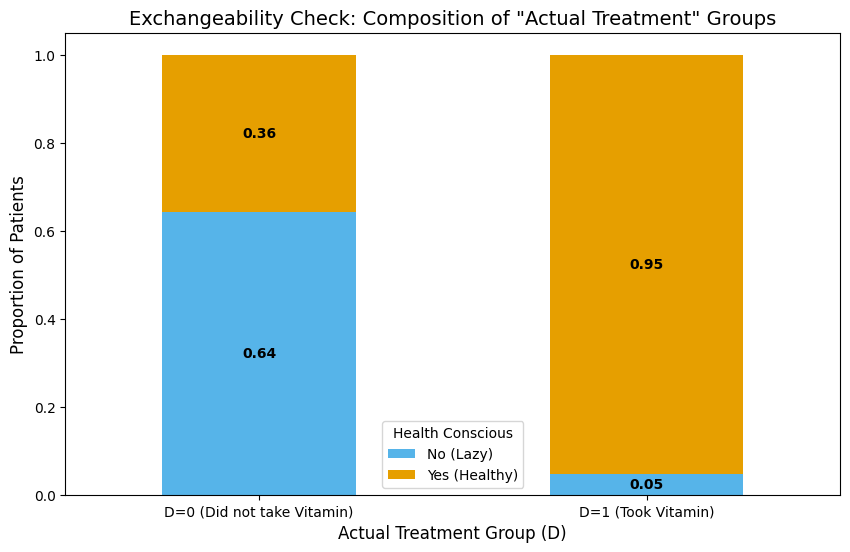

In [95]:
# Visualization of the "Exchangeability" Violation
# We want to see if the groups defined by D (Actual Treatment) look the same in terms of Health Consciousness.

# Create a crosstab of Actual Treatment (D) vs Health Consciousness
# Normalize='index' gives us the proportions within each group (Row percentages)
exchangeability_check = pd.crosstab(df['D'], df['is_health_conscious'], normalize='index')

# Plotting
ax = exchangeability_check.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#56B4E9', '#E69F00'])

plt.title('Exchangeability Check: Composition of "Actual Treatment" Groups', fontsize=14)
plt.xlabel('Actual Treatment Group (D)', fontsize=12)
plt.ylabel('Proportion of Patients', fontsize=12)
plt.xticks([0, 1], ['D=0 (Did not take Vitamin)', 'D=1 (Took Vitamin)'], rotation=0)
plt.legend(title='Health Conscious', labels=['No (Lazy)', 'Yes (Healthy)'], loc='best')

# Add percentage labels
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='center', color='black', weight='bold')

plt.show()

Because the actual treatment and control groups aren't comparable, we wont' know if the effect was due to health consciousness or the vitamin, which is why our estimate is biased.

In [96]:
# ITT: analyze everyone based on the treatment they were assigned to
itt_model = smf.ols('health_score ~ Z', data=df).fit()
print(itt_model.summary())

                            OLS Regression Results                            
Dep. Variable:           health_score   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     241.1
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           9.75e-54
Time:                        21:49:24   Log-Likelihood:                -32261.
No. Observations:               10000   AIC:                         6.453e+04
Df Residuals:                    9998   BIC:                         6.454e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.1195      0.086    871.669      0.0

The ITT captures the effect of giving the patient the option to take the vitamin, not the effect of taking the vitamin itself. This means we are answering a different causal question about giving patients the option to take the vitamin rather than taking the vitamin. 

When we are doing policy analysis on whether we should make this vitamin available or not, the ITT might be more useful because not all people who can get the vitamin will end up taking it. The ITT gives us an idea of the average outcome a person who is given the option to take the vitamin will be.

Notice that when we take the ITT approach, the groups are still exchangeable.

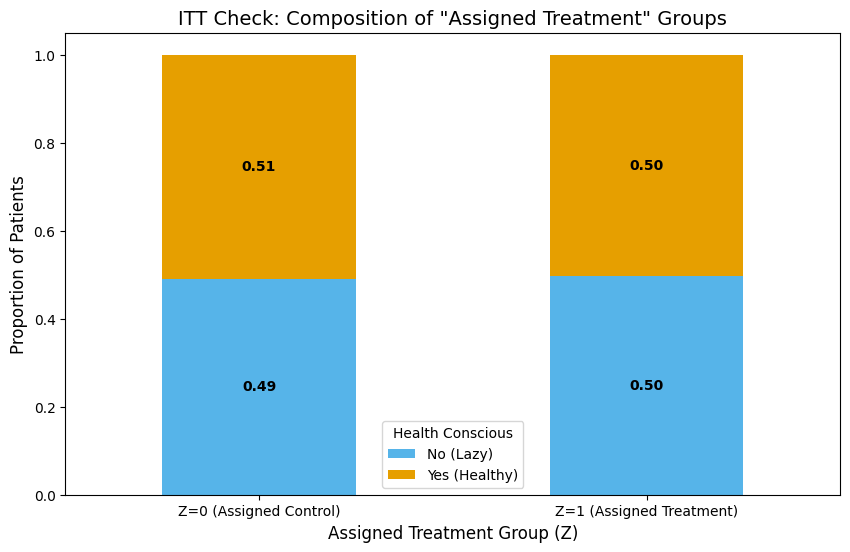

In [100]:
# Visualization of Exchangeability in ITT
# We want to see if the groups defined by Z (Assigned Treatment) look the same.

# Create a crosstab of Assigned Treatment (Z) vs Health Consciousness
exchangeability_check_itt = pd.crosstab(df['Z'], df['is_health_conscious'], normalize='index')

# Plotting
ax = exchangeability_check_itt.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#56B4E9', '#E69F00'])

plt.title('ITT Check: Composition of "Assigned Treatment" Groups', fontsize=14)
plt.xlabel('Assigned Treatment Group (Z)', fontsize=12)
plt.ylabel('Proportion of Patients', fontsize=12)
plt.xticks([0, 1], ['Z=0 (Assigned Control)', 'Z=1 (Assigned Treatment)'], rotation=0)
plt.legend(title='Health Conscious', labels=['No (Lazy)', 'Yes (Healthy)'], loc='best')

# Add percentage labels
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='center', color='black', weight='bold')

plt.show()